In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

binary_warped.shape: (720, 1280)


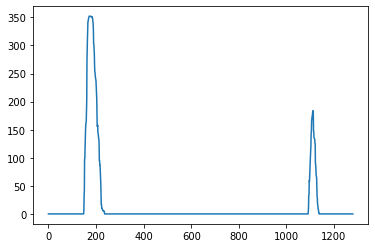

In [56]:
image_name = "intermediate_images/test5-warped-binary.jpg"
binary_warped = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE) # IMREAD_GRAYSCALE needed b/c of: https://stackoverflow.com/questions/18870603/in-opencv-python-why-am-i-getting-3-channel-images-from-a-grayscale-image
print("binary_warped.shape: {}".format(binary_warped.shape))
binary_warped_top_half = binary_warped[binary_warped.shape[0]//2:,:]

histogram = np.sum(binary_warped_top_half, axis=0)
plt.plot(histogram)

In [57]:

midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("histo shape: {}".format(histogram.shape))
max_val = np.argmax(histogram[:][0])
print("max: {}".format(max_val))
print("midpoint: {}, leftx_base: {}, rightx_base: {}".format(midpoint, leftx_base, rightx_base))

histo shape: (1280,)
max: 0
midpoint: 640, leftx_base: 171, rightx_base: 1112


## Split histogram into individual lanes

In [58]:

# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

## Set up windows and window hyperparameters


In [59]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped_top_half.shape[0]//nwindows)
    
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
# Returns a row_major tuple of: (y_coords, x_coords)
nonzero = binary_warped_top_half.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

In [31]:
print("binary_warped_top_half.shape: {}".format(binary_warped_top_half.shape))
print(len(binary_warped_top_half.nonzero()[0]))


binary_warped_top_half.shape: (360, 1280)
21038


## Iterate through nwindows to track curvature

- Loop through each window in `nwindows`
- Find the boundaries of our current window. This is based on a combination of the current window's starting point (`leftx_current` and `rightx_current`), as well as the `margin` you set in the hyperparameters.
- Use `cv2.rectangle` to draw these window boundaries onto our visualization image out_img. This is required for the quiz, but you can skip this step in practice if you don't need to visualize where the windows are.
- Now that we know the boundaries of our window, find out which activated pixels from `nonzeroy` and `nonzerox` above actually fall into the window.
- Append these to our lists `left_lane_inds` and `right_lane_inds`.
- If the number of pixels you found in Step 4 are greater than your hyperparameter minpix, re-center our window (i.e. `leftx_current` or `rightx_current`) based on the mean position of these pixels.

binary_warped_top_half.shape: (360, 1280)
left_lane_bottom_left: (71, 720), left_lane_top_right: (271, 680)


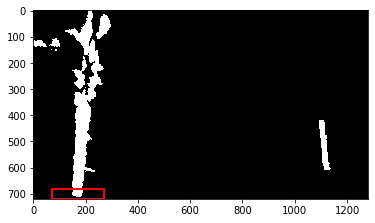

In [51]:
# Experiment with a single window

print("binary_warped_top_half.shape: {}".format(binary_warped_top_half.shape))
window = 9
shift_y = binary_warped_top_half.shape[0]

left_lane_bottom_left_pt_y = int(window * window_height) + shift_y
left_lane_bottom_left_pt_x = int(leftx_current - margin)  
left_lane_top_right_y = int((window * window_height) - window_height) + shift_y
left_lane_top_right_x = int(leftx_current + margin)

left_lane_bottom_left = (left_lane_bottom_left_pt_x, left_lane_bottom_left_pt_y)
left_lane_top_right = (left_lane_top_right_x, left_lane_top_right_y)

print("left_lane_bottom_left: {}, left_lane_top_right: {}".format(left_lane_bottom_left, left_lane_top_right))
cv2.rectangle(out_img, left_lane_bottom_left, left_lane_top_right, 255, 5)
plt.imshow(out_img)

In [61]:
# Helper function to find out which activated 
# pixels from nonzeroy and nonzerox above actually fall into the window.
def get_activated_window(pt1, pt2, nonzero_pts):

    # find min x coord
    min_x = min(pt1[0], pt2[0])
    
    # find max x coord
    max_x = max(pt1[0], pt2[0])
    
    # find min y coord
    min_y = min(pt1[1], pt2[1])
    
    # find max y coord
    max_y = max(pt1[1], pt2[1])

    # return filtered nonzero tuple where points fall within window
    nonzero_filtered = [nonzero_pt for nonzero_pt in np.transpose(nonzero_pts) 
                        if (nonzero_pt[0] >= min_y and 
                            nonzero_pt[0] <= max_y and
                            nonzero_pt[1] >= min_x and
                            nonzero_pt[1] <= max_x) ]
    
    # print("min_x: {} max_x: {} min_y: {} max_y: {}".format(min_x, max_x, min_y, max_y))
                                     
    return nonzero_filtered


In [54]:
def get_updated_window_center(
        current_window_center,
        pt1, 
        pt2, 
        activated,
        is_left):
    
    """
            # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    """
    
    if len(activated) < minpix:
        return current_window_center
    
    # find min y coord
    min_y = min(pt1[1], pt2[1])
    
    # find max y coord
    max_y = max(pt1[1], pt2[1])
    
    print("taking slice from {}:{}".format(min_y, max_y))
    binary_warped_slice = binary_warped[min_y:max_y,:]

    histogram_slice = np.sum(binary_warped_slice, axis=0)
    
    midpoint = np.int(histogram_slice.shape[0]//2)
    leftx_base = np.argmax(histogram_slice[:midpoint])
    rightx_base = np.argmax(histogram_slice[midpoint:]) + midpoint
    
    if is_left:
        print("changing left window center from {} -> {}".format(current_window_center, leftx_base))

        return leftx_base
    else:
        print("changing right window center from {} -> {}".format(current_window_center, rightx_base))

        return rightx_base
    
    

min_x: 71 max_x: 271 min_y: 680 max_y: 720
len(activated_left_lane): 1143
min_x: 996 max_x: 1196 min_y: 680 max_y: 720
len(activated_right_lane): 0
taking slice from 680:720
changing left window center from 171 -> 166
left_lane_bottom_left: (71, 680) left_lane_top_right: (271, 720)
right_lane_bottom_left: (996, 680) right_lane_top_right: (1196, 720)
min_x: 66 max_x: 266 min_y: 640 max_y: 680
len(activated_left_lane): 1644
min_x: 996 max_x: 1196 min_y: 640 max_y: 680
len(activated_right_lane): 0
taking slice from 640:680
changing left window center from 166 -> 184
left_lane_bottom_left: (66, 640) left_lane_top_right: (266, 680)
right_lane_bottom_left: (996, 640) right_lane_top_right: (1196, 680)
min_x: 84 max_x: 284 min_y: 600 max_y: 640
len(activated_left_lane): 2118
min_x: 996 max_x: 1196 min_y: 600 max_y: 640
len(activated_right_lane): 248
taking slice from 600:640
changing left window center from 184 -> 192
taking slice from 600:640
changing right window center from 1096 -> 1112
lef

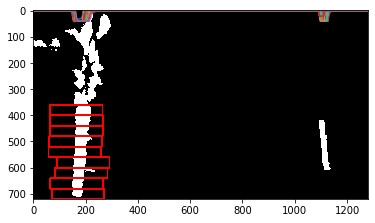

In [55]:
# Create empty lists to receive left and right lane pixel coords
left_lane_coords = []
right_lane_coords = []

shift_y = binary_warped_top_half.shape[0]
for window in reversed(range(nwindows)):
    
    # this is the "bottom" in the reference frame of the image coord system, but 
    # the "top" if you're looking at it in the (flipped) screen coord system.
    win_y_bottom = window * window_height + shift_y
    
    # conversely, this is the "top" in the reference frame of the image coord system
    win_y_top = (window+1) * window_height + shift_y
    
    # Calculate left left x coords
    left_lane_bottom_left_pt_x = int(leftx_current - margin)  
    left_lane_top_right_x = int(leftx_current + margin)

    # Calculate left lane rectangle points
    left_lane_bottom_left = (left_lane_bottom_left_pt_x, win_y_bottom)
    left_lane_top_right = (left_lane_top_right_x, win_y_top)
    
    # Calculate right light x coords
    right_lane_bottom_left_pt_x = int(rightx_current - margin)  
    right_lane_top_right_x = int(rightx_current + margin)

    # Calculate right lane rectangle points
    right_lane_bottom_left = (right_lane_bottom_left_pt_x, win_y_bottom)
    right_lane_top_right = (right_lane_top_right_x, win_y_top)
    
    # Now that we know the boundaries of our window, find out which activated 
    # pixels from nonzeroy and nonzerox above actually fall into the window.
    activated_left_lane = get_activated_window(
        left_lane_bottom_left, 
        left_lane_top_right, 
        binary_warped.nonzero())
    print("len(activated_left_lane): {}".format(len(activated_left_lane)))
    left_lane_coords.append(activated_left_lane)
    
    activated_right_lane = get_activated_window(
        right_lane_bottom_left, 
        right_lane_top_right, 
        binary_warped.nonzero())
    print("len(activated_right_lane): {}".format(len(activated_right_lane)))
    right_lane_coords.append(activated_right_lane)
    
    # If the number of pixels you found in Step 4 are greater than your 
    # hyperparameter minpix, re-center our window (i.e. leftx_current or rightx_current) based on the mean position of these pixels.
    leftx_current = get_updated_window_center(
        leftx_current,
        left_lane_bottom_left, 
        left_lane_top_right, 
        activated_left_lane,
        is_left=True,
    )
    rightx_current = get_updated_window_center(
        rightx_current,
        right_lane_bottom_left, 
        right_lane_top_right, 
        activated_right_lane,
        is_left=False,
    )
    
    cv2.rectangle(out_img, left_lane_bottom_left, left_lane_top_right, 255, 5)
    
    # Append these to our lists left_lane_inds and right_lane_inds.
    
    print("left_lane_bottom_left: {} left_lane_top_right: {}".format(left_lane_bottom_left, left_lane_top_right))
    print("right_lane_bottom_left: {} right_lane_top_right: {}".format(right_lane_bottom_left, right_lane_top_right))

plt.imshow(out_img)

In [ ]:
for window in range(1):
    print("leftx_current: {}, rightx_current: {}, window_height: {}".format(leftx_current, rightx_current, window_height))
    
    left_lane_bottom_left_pt_y = int(window * window_height)
    left_lane_bottom_left_pt_x = int(leftx_current - margin)  
    left_lane_top_right_y = int((window * window_height) - window_height)
    left_lane_top_right_x = int(leftx_current + margin)
    
    left_lane_bottom_left = (left_lane_bottom_left_pt_x, left_lane_bottom_left_pt_y)
    left_lane_top_right = (left_lane_top_right_x, left_lane_top_right_y)
    
    print("left_lane_bottom_left: {}, left_lane_top_right: {}".format(left_lane_bottom_left, left_lane_top_right))
    #cv2.rectangle(binary_warped, bottom_left, top_right, (255,0,0), 5)  # TypeError: an integer is required (got type tuple)
    #cv2.rectangle(binary_warped, bottom_left, top_right, 255)
    
    #print(window)
    
#plt.imshow(cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY), cmap='gray')


In [ ]:
help(cv2.rectangle)